In [12]:
import sys
import h5py
sys.path.append("/scr/aliang80/diffusion_policy/")
from typing import List
from tqdm import tqdm
import numpy as np
import robomimic.utils.env_utils as EnvUtils
import robomimic.utils.obs_utils as ObsUtils
import robomimic.utils.file_utils as FileUtils
from diffusion_policy.common.replay_buffer import ReplayBuffer
from diffusion_policy.model.common.rotation_transformer import RotationTransformer
from diffusion_policy.dataset.robomimic_replay_lowdim_dataset import _data_to_obs
from diffusion_policy.env.robomimic.robomimic_lowdim_wrapper import (
    RobomimicLowdimWrapper,
)
import matplotlib.pyplot as plt

augmentation_dataset_paths = ["/scr/aliang80/diffusion_policy/data/robomimic/expert_augmentations_30"]

obs_keys = ['object', 'robot0_eef_pos', 'robot0_eef_quat', 'robot0_gripper_qpos']
abs_action = False 
rotation_transformer = None

replay_buffer = ReplayBuffer.create_empty_numpy()

n_aug_episodes = 0
n_aug_steps = 0
if augmentation_dataset_paths is not None:
    for path in augmentation_dataset_paths:
        aug_buffer = ReplayBuffer.create_from_path(path)

        count = 0
        count_steps = 0

        for episode_indx in range(aug_buffer.n_episodes):
            episode = aug_buffer.get_episode(episode_indx)
            data = {"obs": episode["obs"], "action": episode["action"], "state": episode["state"]}
            replay_buffer.add_episode(data)
            count += 1
            count_steps += episode["obs"].shape[0]

        n_aug_episodes += count
        n_aug_steps += count_steps

In [28]:
def create_env(env_meta, obs_keys):
    ObsUtils.initialize_obs_modality_mapping_from_dict({"low_dim": obs_keys})
    env = EnvUtils.create_env_from_metadata(
        env_meta=env_meta,
        render=False,
        # only way to not show collision geometry
        # is to enable render_offscreen
        # which uses a lot of RAM.
        render_offscreen=False,
        use_image_obs=False,
    )
    return env

env_meta = FileUtils.get_env_metadata_from_dataset("/scr/aliang80/diffusion_policy/data/robomimic/datasets/square/ph/low_dim_abs.hdf5")
# rotation_transformer = None
obs_keys = ['object', 'robot0_eef_pos', 'robot0_eef_quat', 'robot0_gripper_qpos']
env_meta["env_kwargs"]["controller_configs"]["control_delta"] = False
# rotation_transformer = RotationTransformer("axis_angle", "rotation_6d")
env = create_env(env_meta, obs_keys)
wrapped_env = RobomimicLowdimWrapper(env)
wrapped_env.reset()
print(wrapped_env.action_space, wrapped_env.observation_space)

Created environment with name NutAssemblySquare
Action size is 7
ROBOMIMIC WARNING(
    No environment version found in dataset!
    Cannot verify if dataset and installed environment versions match
)
Box([-1 -1 -1 -1 -1 -1 -1], [1 1 1 1 1 1 1], (7,), int64) Box([-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1.], [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.], (23,), float64)


[[ 4.25000000e+00  1.44946896e-01  1.16617767e+00 ... -1.93786111e-12
   6.85105492e-06 -2.42364084e-17]
 [ 4.30000000e+00  1.43522994e-01  1.21690841e+00 ... -1.93782019e-12
   6.85105492e-06 -2.42372476e-17]
 [ 4.35000000e+00  1.43129218e-01  1.26870952e+00 ... -1.93780289e-12
   6.85105492e-06 -2.42370352e-17]
 ...
 [ 5.60000000e+00  1.73215534e-01  1.63262142e+00 ... -1.93784066e-12
   6.85105492e-06 -2.42369939e-17]
 [ 5.65000000e+00  1.71153034e-01  1.62762234e+00 ... -1.93782390e-12
   6.85105492e-06 -2.42371218e-17]
 [ 5.70000000e+00  1.70403495e-01  1.62151936e+00 ... -1.93780840e-12
   6.85105492e-06 -2.42372250e-17]]
(11989, 23)


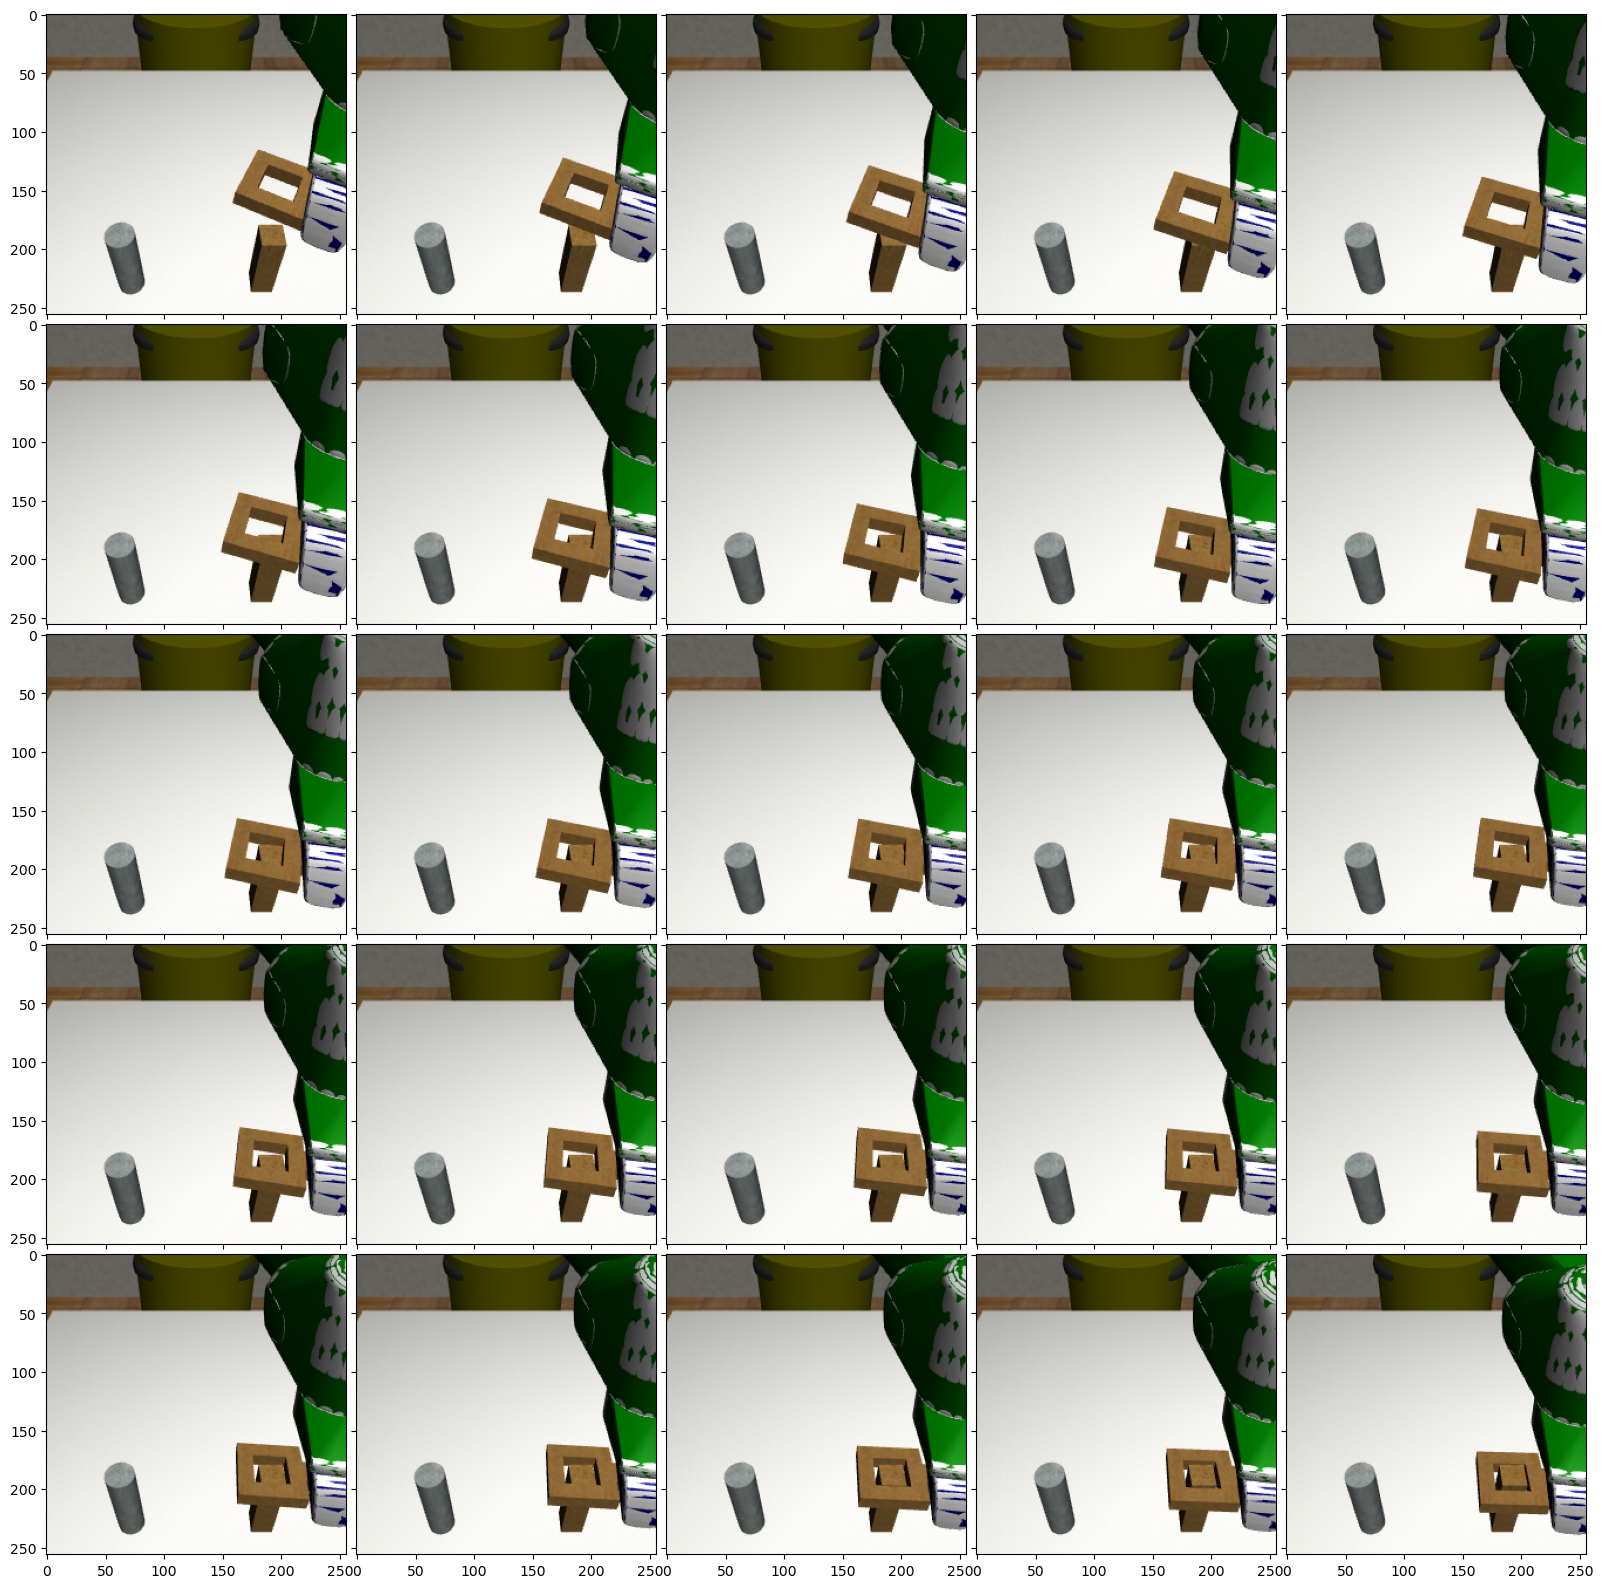

In [31]:
episode = replay_buffer.get_episode(3)
obs = episode["obs"]
print(episode["state"])
print(replay_buffer["obs"].shape)

frames = []
for indx in range(30):
    wrapped_env.env.reset_to({"states": episode["state"][indx]})
    img = wrapped_env.render(mode="rgb_array")
    frames.append(img)

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(20., 20.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(5, 5),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, frames):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

In [33]:
import torch 
from torch.utils.data.sampler import Sampler    

def chunk(indices, chunk_size):
    return torch.split(torch.tensor(indices), chunk_size)


class DemoAndAugmentationBatchSampler(Sampler):
    def __init__(self, demo_data, augmentation_data, batch_size=32):
        # half the batch should come from the demo data and half from the augmentation data
        self.demo_data = demo_data
        self.augmentation_data = augmentation_data
        self.demo_indices = np.arange(demo_data.shape[0])
        self.augmentation_indices = (
            np.arange(augmentation_data.shape[0]) + demo_data.shape[0]
        )
        self.batch_size = batch_size

    def __iter__(self):
        np.random.shuffle(self.demo_indices)
        np.random.shuffle(self.augmentation_indices)

        demo_batches = chunk(self.demo_indices, self.batch_size // 2)
        augmentation_batches = chunk(self.augmentation_indices, self.batch_size // 2)

        # drop the last one for batching reasons
        demo_batches = demo_batches[:-1]
        augmentation_batches = augmentation_batches[:-1]

        combined = []
        num_demo_batches = len(demo_batches)
        num_augmentation_batches = len(augmentation_batches)

        if num_augmentation_batches > num_demo_batches:
            for indx, batch in enumerate(augmentation_batches):
                if indx < num_demo_batches:
                    combined.append(torch.cat([demo_batches[indx], batch]))
                else:
                    # sample random demo_batch
                    demo_batch = demo_batches[np.random.randint(num_demo_batches)]
                    combined.append(torch.cat([demo_batch, batch]))
        else:
            for indx, batch in enumerate(demo_batches):
                if indx < num_augmentation_batches:
                    combined.append(torch.cat([batch, augmentation_batches[indx]]))
                else:
                    # sample random augmentation_batch
                    augmentation_batch = augmentation_batches[
                        np.random.randint(num_augmentation_batches)
                    ]
                    combined.append(torch.cat([batch, augmentation_batch]))

        combined = [batch.tolist() for batch in combined]
        np.random.shuffle(combined)
        return iter(combined)

    def __len__(self):
        return (
            len(self.demo_indices) + len(self.augmentation_indices)
        ) // self.batch_size
    
demo_data = np.random.randn(100, 4)
augmentation_data = {"obs": np.random.randn(100, 4), "action": np.random.randn(100, 2), "state": np.random.randn(100, 2)}
sampler = DemoAndAugmentationBatchSampler(demo_data, augmentation_data, batch_size=32)
print(len(sampler))
for x in sampler:
    print(x)

AttributeError: 'dict' object has no attribute 'shape'

In [25]:
for x in sampler:
    print(x)

[169, 126, 63, 105, 75, 77, 98, 33, 159, 70, 72, 98, 72, 101, 85, 25]
[107, 109, 115, 96, 146, 138, 42, 79, 7, 94, 37, 164, 60, 77, 62, 165]
[146, 117, 5, 102, 151, 66, 97, 170, 151, 84, 115, 91, 29, 177, 102, 61]
[123, 183, 127, 108, 75, 170, 89, 130, 90, 166, 104, 84, 47, 138, 73, 39]
[77, 129, 102, 122]
[128, 135, 78, 121, 117, 161, 93, 92, 109, 21, 60, 128, 54, 122, 153, 52]
[29, 149, 116, 143, 95, 24, 67, 115, 81, 92, 86, 101, 109, 27, 126, 150]
